In [1]:
from gerrychain import Graph

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    population = G.nodes[node]['TOTPOP']
    print("Node",node,"represents",name,"County and its population in year 2010 was",population)

Node 0 represents Payne County and its population in year 2010 was 77350
Node 1 represents Caddo County and its population in year 2010 was 29600
Node 2 represents Delaware County and its population in year 2010 was 41487
Node 3 represents Marshall County and its population in year 2010 was 15840
Node 4 represents Greer County and its population in year 2010 was 6239
Node 5 represents Coal County and its population in year 2010 was 5925
Node 6 represents Seminole County and its population in year 2010 was 25482
Node 7 represents Murray County and its population in year 2010 was 13488
Node 8 represents Jefferson County and its population in year 2010 was 6472
Node 9 represents Tillman County and its population in year 2010 was 7992
Node 10 represents McIntosh County and its population in year 2010 was 20252
Node 11 represents Choctaw County and its population in year 2010 was 15205
Node 12 represents Harper County and its population in year 2010 was 3685
Node 13 represents Grant County 

In [4]:
# We will instead use 2019 population numbers (according to DRA).

population_2019 = {
        'Adair' : 22220,
        'Alfalfa' : 5847,
        'Atoka' : 13823,
        'Beaver' : 5377,
        'Beckham' : 22268,
        'Blaine' : 9556,
        'Bryan' : 46457,
        'Caddo' : 29242,
        'Canadian' : 140455,
        'Carter' : 48319,
        'Cherokee' : 48664,
        'Choctaw' : 14807,
        'Cimarron' : 2174,
        'Cleveland' : 279274,
        'Coal' : 5581,
        'Comanche' : 121762,
        'Cotton' : 5858,
        'Craig' : 14390,
        'Creek' : 71427,
        'Custer' : 29152,
        'Delaware' : 42433,
        'Dewey' : 4922,
        'Ellis' : 4015,
        'Garfield' : 61898,
        'Garvin' : 27835,
        'Grady' : 55071,
        'Grant' : 4397,
        'Greer' : 5861,
        'Harmon' : 2710,
        'Harper' : 3760,
        'Haskell' : 12687,
        'Hughes' : 13372,
        'Jackson' : 25063,
        'Jefferson' : 6158,
        'Johnston' : 11064,
        'Kay' : 44402,
        'Kingfisher' : 15694,
        'Kiowa' : 8886,
        'Latimer' : 10348,
        'Le Flore' : 50026,
        'Lincoln' : 34895,
        'Logan' : 46683,
        'Love' : 10063,
        'McClain' : 39247,
        'McCurtain' : 33016,
        'McIntosh' : 19725,
        'Major' : 7692,
        'Marshall' : 16505,
        'Mayes' : 41044,
        'Murray' : 13946,
        'Muskogee' : 68736,
        'Noble' : 11335,
        'Nowata' : 10322,
        'Okfuskee' : 12067,
        'Oklahoma' : 787216,
        'Okmulgee' : 38749,
        'Osage' : 47226,
        'Ottawa' : 31454,
        'Pawnee' : 16412,
        'Payne' : 81815,
        'Pittsburg' : 44146,
        'Pontotoc' : 38355,
        'Pottawatomie' : 72154,
        'Pushmataha' : 11128,
        'Roger Mills' : 3667,
        'Rogers' : 91353,
        'Seminole' : 24832,
        'Sequoyah' : 41709,
        'Stephens' : 43647,
        'Texas' : 20805,
        'Tillman' : 7413,
        'Tulsa' : 646419,
        'Wagoner' : 78958,
        'Washington' : 51886,
        'Washita' : 11225,
        'Woods' : 9043,
        'Woodward' : 20727                   
}

In [5]:
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    G.nodes[node]['POP19'] = population_2019[name]
    
print("population of Payne County is",G.nodes[0]['POP19'])

population of Payne County is 81815


In [6]:
# what is the total 2019 population?
total_population_2019 = sum( G.nodes[i]['POP19'] for i in G.nodes )

# Let's set lower and upper population bounds on the districts
k = 101              # number of districts
deviation = 0.05     # 5% deviation (+/-2.5%)

import math
L = math.ceil( (1 - deviation / 2) * total_population_2019 / k )
U = math.floor( (1 + deviation / 2) * total_population_2019 / k )

print("Total population =",total_population_2019)
print("Desired number of districts =",k)
print("Ideal population =",total_population_2019 / k)
print("Lower population threshold =",L)
print("Upper population threshold =",U)

Total population = 3932870
Desired number of districts = 101
Ideal population = 38939.30693069307
Lower population threshold = 37966
Upper population threshold = 39912


In [7]:
# Let's find a large subset of counties B with the property 
#    that every component of G[B] has population less than L.
#
# This is used to help speed up the computations, but has no 
#    bearing on the final results themselves.

import networkx as nx
DG = nx.DiGraph(G) # bidirected version of G

import gurobipy as gp
from gurobipy import GRB

bm = gp.Model()

# X[i,j]=1 if vertex i is assigned to bin j
bX = bm.addVars(DG.nodes, k, vtype=GRB.BINARY) 

# B[i]=1 if vertex i is selected
bB = bm.addVars(DG.nodes, vtype=GRB.BINARY)

# set objective, maximize number of vertices in B
bm.setObjective( gp.quicksum( bB[i] for i in DG.nodes ), GRB.MAXIMIZE )

# relate X and B vars
bm.addConstrs( bB[i] == gp.quicksum( bX[i,j] for j in range(k) ) for i in DG.nodes)

# bin capacity constraints
bm.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * bX[i,j] for i in G.nodes ) <= L-1 for j in range(k) )

# bin conflict constraints
bm.addConstrs( bX[u,j] + bB[v] <= 1 + bX[v,j] for u,v in DG.edges for j in range(k) )

# solve and return B
bm.Params.TimeLimit = 60
bm.optimize()

B = [i for i in DG.nodes if bB[i].x > 0.5]
B_names = [ G.nodes[i]['NAME10'] for i in B ]

print("B =",B)
print("B county names =",B_names)

Academic license - for non-commercial use only - expires 2021-04-22
Using license file C:\Users\buchanan\gurobi.lic
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 39568 rows, 7854 columns and 133801 nonzeros
Model fingerprint: 0xb9fef367
Variable types: 0 continuous, 7854 integer (7854 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 24673 rows and 2958 columns
Presolve time: 0.34s
Presolved: 14895 rows, 4896 columns, 53891 nonzeros
Variable types: 0 continuous, 4896 integer (4896 binary)

Root relaxation: objective 4.800000e+01, 6011 iterations, 1.23 seconds

    Nodes    |    Current Node    |     Objective Bo

In [8]:
# function used in sorting step in an upcoming cell
def sort_by_second(val):
    return val[1]   

In [9]:
# Solve county clustering problem:
#
# Group the counties into contiguous clusters so that each has
#   population that is an integer multiple of the ideal population     
#

m = gp.Model()

# X[i,j]=1 if vertex i is assigned to (cluster centered at) vertex j
X = m.addVars(DG.nodes, DG.nodes, vtype=GRB.BINARY) 

# Y[j] = # of clusters centered at vertex j
Y = m.addVars(DG.nodes, vtype=GRB.INTEGER)

# Set objective function, maximize number of clusters
m.setObjective( gp.quicksum( X[j,j] for j in DG.nodes ), GRB.MAXIMIZE ) 

In [10]:
# Add base constraints

# Each county i assigned to one cluster
m.addConstrs( gp.quicksum( X[i,j] for j in DG.nodes ) == 1 for i in DG.nodes )

# Cluster "sizes" should sum to k
m.addConstr( gp.quicksum(Y[j] for j in DG.nodes) == k )

# Population balance: population of cluster j should be in [L,U] * Y[j]
m.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * X[i,j] for i in DG.nodes ) <= U * Y[j] for j in DG.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * X[i,j] for i in DG.nodes ) >= L * Y[j] for j in DG.nodes )

# Enforce relationships between X[i,j] and X[j,j] and Y[j]
m.addConstrs( X[j,j] <= Y[j] for j in DG.nodes )
m.addConstrs( Y[j] <= DG.number_of_nodes() * X[j,j] for j in DG.nodes )
m.addConstrs(X[i,j] <= X[j,j] for i in DG.nodes for j in DG.nodes)

m.update()

In [11]:
# Add contiguity constraints

# F[j,u,v] tells how much flow (from source j) is sent across arc (u,v)
F = m.addVars(DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)
M = DG.number_of_nodes() - 1
for j in DG.nodes:
    m.addConstr( sum(F[j,u,j] for u in DG.neighbors(j) ) == 0 )
    for i in DG.nodes:
        if i!=j:
            m.addConstr( sum(F[j,u,i] for u in DG.neighbors(i) ) - sum(F[j,i,u] for u in DG.neighbors(i)) == X[i,j] )
            m.addConstr( sum(F[j,u,i] for u in DG.neighbors(i) ) <= M * X[i,j] )

In [12]:
# This cell: computational speedups 

# Set branch priority on center vars
for j in DG.nodes:
    X[j,j].BranchPriority = 1
    Y[j].BranchPriority = 1
        
# Variable fixing based on set B
V_B_with_population = [(i,G.nodes[i]['POP19']) for i in G.nodes if i not in B]
V_B_with_population.sort(key=sort_by_second,reverse=True)
ordering = [v for (v,p) in V_B_with_population] + B   

# diagonal fixing based on ordering
for p in range(len(ordering)):
    i = ordering[p]
    for q in range(p+1,len(ordering)):
        j = ordering[q]
        X[i,j].UB = 0

# L fixing
for i in DG.nodes:
    for j in B:
        X[i,j].UB = 0

In [13]:
# solve
m.Params.TimeLimit = 7200 # 2-hour time limit
m.optimize()

Changed value of parameter TimeLimit to 7200.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 18096 rows, 36036 columns and 131044 nonzeros
Model fingerprint: 0xd3c3e050
Variable types: 30030 continuous, 6006 integer (5929 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 11661 rows and 25437 columns
Presolve time: 0.34s
Presolved: 6435 rows, 10599 columns, 40296 nonzeros
Variable types: 8322 continuous, 2277 integer (2222 binary)
Found heuristic solution: objective 3.0000000

Root relaxation: objective 4.432815e+01, 921 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

  1196   868   29.00000   33  526   27.00000   29.47024  9.15%  2047  470s
  1200   871   28.98631   24  484   27.00000   29.46467  9.13%  2041  475s
  1205   874   28.98667   38  517   27.00000   29.46096  9.11%  2032  480s
  1209   877   28.00000   30  545   27.00000   29.45701  9.10%  2025  485s
  1213   879   29.44959   18  588   27.00000   29.44959  9.07%  2019  490s
  1219   883   29.00000   41  580   27.00000   29.44389  9.05%  2009  497s
  1221   885   29.44152   16  539   27.00000   29.44152  9.04%  2005  502s
  1224   887   29.44015   12  493   27.00000   29.44015  9.04%  2001  505s
  1230   891   28.00000   37  497   27.00000   29.43605  9.02%  1991  511s
  1234   893   29.43453   17  573   27.00000   29.43453  9.02%  1984  516s
  1237   895   28.81080   31  559   27.00000   29.43339  9.01%  1980  520s
  1246   903   29.43202   26  389   27.00000   29.43202  9.01%  2309  526s
  1248   904   29.00000   27  341   27.00000   29.43202  9.01%  2305  531s
  1251   906   29.43202  

  1856  1267   28.00000   52  384   28.00000   29.29411  4.62%  1803 1020s
  1866  1274   29.29183   21  428   28.00000   29.29183  4.61%  1794 1025s
  1873  1278   29.28924   31  378   28.00000   29.28924  4.60%  1787 1030s
  1885  1286   29.28734   10  425   28.00000   29.28734  4.60%  1776 1035s
  1893  1292   28.00000   52  466   28.00000   29.28444  4.59%  1768 1040s
  1901  1297   29.28333    9  457   28.00000   29.28333  4.58%  1761 1045s
  1911  1304   28.98937   29  484   28.00000   29.28188  4.58%  1751 1050s
  1917  1308   29.28138   36  475   28.00000   29.28138  4.58%  1746 1055s
  1923  1312   29.28116   17  480   28.00000   29.28116  4.58%  1741 1060s
  1934  1320   29.28113   17  291   28.00000   29.28113  4.58%  1765 1065s
  1939  1323   29.00000   29  340   28.00000   29.28113  4.58%  1760 1070s
  1945  1327   28.81080   31  366   28.00000   29.28113  4.58%  1755 1075s
  1951  1331   29.27607    9  387   28.00000   29.27607  4.56%  1749 1080s
  1960  1337   29.00000  

  2789  1901   29.16556   16  433   28.00000   29.16556  4.16%  1458 1570s
  2803  1910   29.16384   22  440   28.00000   29.16384  4.16%  1451 1575s
  2811  1916   28.98937   29  487   28.00000   29.16281  4.15%  1447 1580s
  2823  1924   29.16213   17  456   28.00000   29.16213  4.15%  1441 1585s
  2833  1930   29.00000   33  436   28.00000   29.16112  4.15%  1435 1590s
  2843  1937   29.16073   24  429   28.00000   29.16073  4.15%  1430 1595s
  2856  1947   28.00000   52  378   28.00000   29.16070  4.15%  1467 1600s
  2862  1951   29.16070   40  449   28.00000   29.16070  4.15%  1464 1605s
  2867  1955   29.16070   24  413   28.00000   29.16070  4.15%  1462 1610s
  2875  1960   29.15843    8  439   28.00000   29.15843  4.14%  1458 1615s
  2887  1968   28.00000   59  404   28.00000   29.15749  4.13%  1452 1620s
  2900  1977   28.98631   24  408   28.00000   29.15675  4.13%  1445 1625s
  2912  1985   29.15556   13  401   28.00000   29.15556  4.13%  1439 1630s
  2927  1995   29.00000  

  3881  2650   29.11806    7  441   28.00000   29.11806  3.99%  1292 2120s
  3888  2654   28.74540   31  422   28.00000   29.11765  3.99%  1290 2125s
  3899  2662   29.11687   13  441   28.00000   29.11687  3.99%  1286 2130s
  3914  2673   29.11669    9  338   28.00000   29.11669  3.99%  1300 2135s
  3920  2677   28.98603   42  338   28.00000   29.11669  3.99%  1298 2140s
  3927  2682   29.00000   29  416   28.00000   29.11669  3.99%  1295 2145s
  3934  2686   29.11669   17  405   28.00000   29.11669  3.99%  1293 2150s
  3942  2692   29.11604   18  434   28.00000   29.11604  3.99%  1291 2155s
  3955  2700   28.00000   30  388   28.00000   29.11533  3.98%  1286 2160s
  3969  2710   29.11462   19  414   28.00000   29.11462  3.98%  1282 2165s
  3982  2719   29.11459   20  288   28.00000   29.11459  3.98%  1291 2170s
  3989  2724   29.11459   16  415   28.00000   29.11459  3.98%  1289 2175s
  3998  2730   28.00000   56  396   28.00000   29.11439  3.98%  1286 2180s
  4009  2737   28.00000  

Thread count was 8 (of 8 available processors)

Solution count 10: 28 27 26 ... 18

Optimal solution found (tolerance 1.00e-04)
Best objective 2.800000000000e+01, best bound 2.800000000000e+01, gap 0.0000%


In [14]:
# What are the cluster "centers"?
centers = [j for j in DG.nodes if Y[j].x > 0.5]

print("********************************")
print("********************************")

# Print info about each cluster
clusters = list()
for j in centers:
    cluster_nodes = [ i for i in DG.nodes if X[i,j].x > 0.5 ]
    cluster_names = [ G.nodes[i]['NAME10'] for i in cluster_nodes ]
    cluster_population = sum( G.nodes[node]['POP19'] for node in cluster_nodes )
    cluster_size = int(Y[j].x)
    print("Cluster rooted at node",j,"(",G.nodes[j]['NAME10']," County ) has total population",cluster_population,"and should be split into",cluster_size,"district(s).")
    print("Cluster nodes are",cluster_nodes,"which correspond to counties:",cluster_names)
    print("Average district in this cluster should have population",cluster_population/cluster_size)
    print("********************************")
    print("********************************")
    clusters.append(cluster_nodes)
    
print("There are",len(clusters),"clusters:",clusters)

********************************
********************************
Cluster rooted at node 0 ( Payne  County ) has total population 116710 and should be split into 3 district(s).
Cluster nodes are [0, 66] which correspond to counties: ['Payne', 'Lincoln']
Average district in this cluster should have population 38903.333333333336
********************************
********************************
Cluster rooted at node 2 ( Delaware  County ) has total population 114931 and should be split into 3 district(s).
Cluster nodes are [2, 36, 43] which correspond to counties: ['Delaware', 'Mayes', 'Ottawa']
Average district in this cluster should have population 38310.333333333336
********************************
********************************
Cluster rooted at node 15 ( Oklahoma  County ) has total population 787216 and should be split into 20 district(s).
Cluster nodes are [15] which correspond to counties: ['Oklahoma']
Average district in this cluster should have population 39360.8
************

In [15]:
# Map the clusters
import geopandas as gpd

filepath = 'C:\\districting-data\\'
filename = 'OK_county.shp'
df = gpd.read_file( filepath + filename )

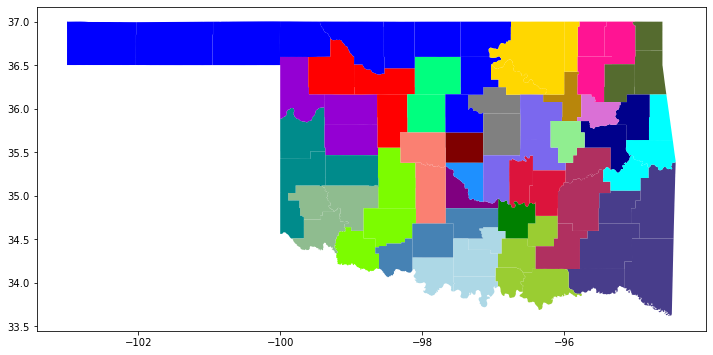

In [16]:
# Which cluster is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(clusters)):
    
    # for each node i in this cluster
    for i in clusters[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
pallette = ['#808080','#556b2f','#7f0000','#483d8b','#008000','#b8860b','#008b8b','#4682b4','#9acd32','#00008b','#8fbc8f','#800080','#b03060','#ff0000','#ffd700','#7cfc00','#9400d3','#00ff7f','#dc143c','#00ffff','#0000ff','#da70d6','#1e90ff','#fa8072','#90ee90','#add8e6','#ff1493','#7b68ee','#ffdead','#ffb6c1']
colors = [pallette[assignment[node]] for node in G.nodes]
df['colors'] = colors
my_fig = df.plot(color=df['colors']).get_figure()
RESIZE_FACTOR = 2
my_fig.set_size_inches(my_fig.get_size_inches()*RESIZE_FACTOR)

In [17]:
# The county clusters can be split in many, many ways. Here is one possible way
import webbrowser

webbrowser.open('https://davesredistricting.org/join/d06eedc6-e949-434a-8efc-f948babdcac2')  

True